# Dataloading
#### Recording ECG with Polar H10

Model Number: H10 
Manufacturer Name: Polar Electro Oy 
Serial Number: 79324520 
Address: F3:6D:6E:2F:7C:18
Battery Level: 100%
Firmware Revision: 5.0.0 
Hardware Revision: 00760690.03 
Software Revision: 3.1.1 


Recording...: 100%|██████████| 60/60 [01:00<00:00,  1.00s/it]

Stopping ECG data...


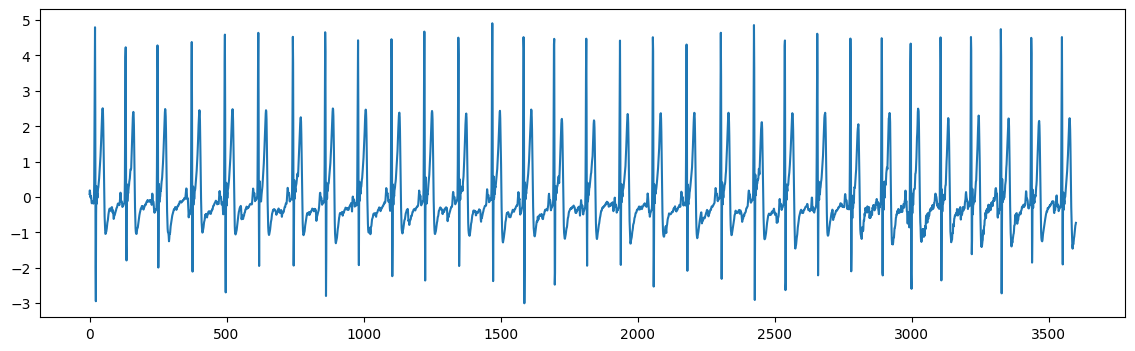

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from preprocessing import lowpass_fir_record, resample_record, normalise_record, crop_random_and_pad_sample
from PolarH10 import record_polar_ecg

record_len = 60 # s
ecg_data = await record_polar_ecg(record_len)

times = ecg_data['times']
ecg = ecg_data['values']
fs = 1/np.mean(np.diff(times))
start_id = int(5*fs) # remove the first 5 seconds
times = times[start_id:]
ecg = ecg[start_id:]

resample_fs = 120
order = 512
cutoff = 60
crop_length = 30
ecg_lp = lowpass_fir_record(ecg, fs, order, cutoff)
ecg_rs = resample_record(ecg_lp, fs, resample_fs)
ecg_n = normalise_record(ecg_rs, np.mean(ecg), np.std(ecg))
sample = crop_random_and_pad_sample(ecg_n, resample_fs, crop_length)
X = np.expand_dims(np.expand_dims(sample, -1), 0)

plt.figure(figsize=(14,4))
plt.plot(sample)

SOURCE = "Polar H10 recording"

#### Pre-recorded ECG
Data can be recorded through the "Polar H10 ECG Analysis" App

EDF file sample rate: 260.0


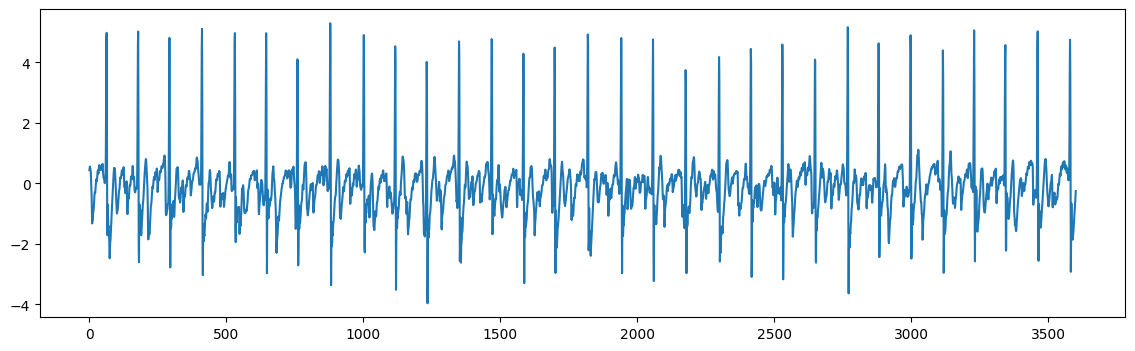

In [10]:
from dataloading import read_ecg_from_edf
from preprocessing import lowpass_fir_record, resample_record, normalise_record, crop_random_and_pad_sample
import numpy as np

edf_dir = 'data/polarh10/'
edf_file = 'kieran_2024-02-13_13-00-12.edf' 
file_path = edf_dir + edf_file
times, ecg = read_ecg_from_edf(file_path)

# Lowpass filter and resample
fs = 260
resample_fs = 120
order = 512
cutoff = 60
crop_length = 30
ecg_lp = lowpass_fir_record(ecg, fs, order, cutoff)
ecg_rs = resample_record(ecg_lp, fs, resample_fs)
ecg_n = normalise_record(ecg_rs, np.mean(ecg), np.std(ecg))

# Crop and pad
sample = crop_random_and_pad_sample(ecg_n, resample_fs, crop_length)
X = np.expand_dims(np.expand_dims(sample, -1), 0)

plt.figure(figsize=(14,4))
plt.plot(sample)

SOURCE = "Pre-recorded"

#### Physionet data loading

In [7]:
# Randomly load in either a AF or Normal ECG
from dataloading import *
from preprocessing import *
import os

CASE = 'A' # A (Atrial Fibrillation) or N (Normal)

db_dir = "data/physionet"
pkl_path = db_dir + "normalisedrecords_fslist_labels.pkl"
cutoff = 60 # Hz
resample_fs = 120 # Hz
crop_length = 30 # s
afib_dup_factor = 3

if not os.path.exists(pkl_path):
    # Read filter, and normalise
    record_list, fs_list, labels = read_challenge17_data(db_dir)
    resampled_records = lowpass_filter_and_resample_record_list(record_list, fs_list, 512, cutoff, resample_fs)
    normalised_records = normalise_record_list(resampled_records)
    # Save it out 
    save_challenge17_pkl(pkl_path, (normalised_records, fs_list, labels))
else:
    # Read in the pkl file
    normalised_records, fs_list, labels = load_challenge17_pkl(pkl_path)

normalised_records, labels = drop_other_class_records_and_labels(normalised_records, labels)
dup_records, labels = duplicate_afib_records_in_list(normalised_records, labels, afib_dup_factor)
records = crop_and_pad_record_list(dup_records, resample_fs, crop_length)
X = np.array(records)
X = np.expand_dims(X, -1)

# Select a random case
case_ids = labels[labels[CASE]].index
rand_case_id = random.choice(case_ids)
X = X[rand_case_id:rand_case_id+1]

SOURCE = "Physionet"

# Inference

1/1 [==============================] - 0s 153ms/step
Normal


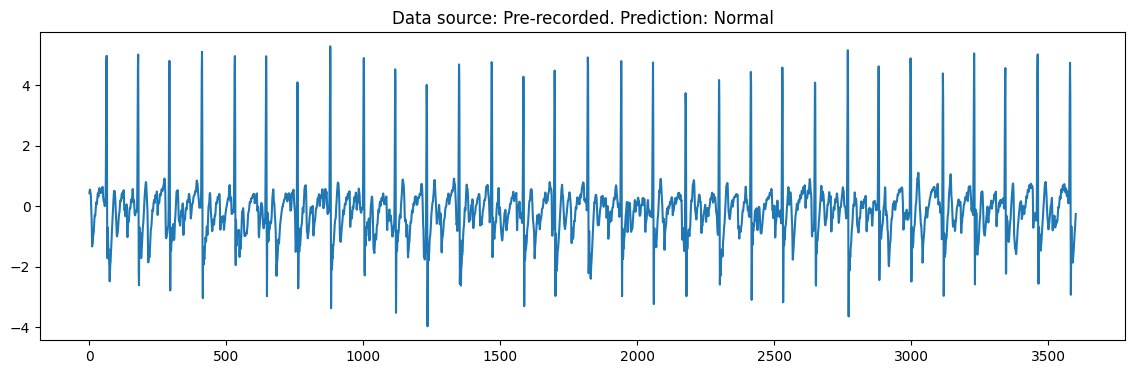

In [11]:
import matplotlib.pyplot as plt
from modelling import create_dual_stream_cnn_model
import tensorflow as tf

# Load model
STREAM2_SIZE = 9

models_path = f"models/baseline/3_{STREAM2_SIZE}/model_weights.h5"
model = create_dual_stream_cnn_model((X.shape[1], 1), stream2_size=STREAM2_SIZE, verbose=0)
model.load_weights(models_path)

# Prediction
prediction = model.predict(X)
predicted_class = "Atrial Fibrillation" if prediction >= 0.5 else "Normal"
tf.keras.backend.clear_session()

print(predicted_class)
plt.figure(figsize=(14,4))
plt.plot(X.flatten())
plt.title(f"Data source: {SOURCE}. Prediction: {predicted_class}")
